# Assignment 01 - The simplest least squares

The assignment consists in completing a python notebook that implements a LS estimator for a scalar quadratic model, i.e.,

$$ y_t = \theta_0 + \theta_1 u_t + \theta_2 u_t^2 + e_t $$ 
         
where the $u_t$'s are 20 uniformly spaced values in $[-1, 1]$. After completing the notebook, you will have to comment the results.

# task 1.1

Generate the $u_t$'s.

In [22]:
# importing the right packages
import numpy as np
import matplotlib.pyplot as plt

In [23]:
# define the function that creates an arbitrary polynomial
# that we will use also to create the scalar quadratic
# 'true model'
#
# note that this function uses both 'lambda functions' and
# the 'enumerate' function -- two features of python
def arbitrary_poly(theta):
    noiseless_y = lambda x: sum([p*(x**i) for i, p in enumerate(theta)])
    return noiseless_y

In [24]:
# for readability
min_u = -1
max_u = 1
N     = 20 # number of samples

# create the u_t's
u = np.random.uniform(min_u, max_u, N)

# task 1.2

Create the 20 i.i.d. additive noise values $e_t$ by following a mixture model.

More precisely, let $e_t$ be with probability $\alpha$ be a zero mean, $\sigma^2$ variance Gaussian, and with probability $1 - \alpha$ a zero mean, scale $\beta$ Laplacian.

Keep $\alpha$ be a parameter that will be tuned later on.

In [25]:
# Non-random generation between code executions.
# Comment out if you want to repeat the same experiment over and over again
# np.random.seed(123)

In [26]:
# define the function for the mixture distribution
def noise(alpha, beta, sigma, N):
    if np.random.uniform() < alpha:
        noise = np.random.normal(0, sigma, N)
    else:
        noise = np.random.laplace(0, beta, N)
    return noise

# task 1.3

Code the LS estimator as a function whose inputs are the vector of $u_t$'s, the vector of $y_t$'s, and the true $\overline{\theta} = \left[ \theta_0, \theta_1, \theta_2 \right]^T$.

Let the outputs of the function be the estimated parameters and the Euclidean distance $d$ between the true parameters and the estimated ones.

In [38]:
# define the function solving the LS problem asked in the assignment
from scipy.optimize import minimize
def LS_solver( u, y, theta_true ):

    # create the features matrix, i.e.
    # | u(1)^0   u(1)^1   u(1)^2 |
    # | u(2)^0   u(2)^1   u(2)^2 |
    # | ...      ...      ...    |
    # | u(N)^0   u(N)^1   u(N)^2 |
    U = np.array([[u[i]**0, u[i]**1, u[i]**2] for i in range(len(u))])

    # compute the LS estimate by using some numerical optimization tool
    # tip1: see https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html
    # tip2: write the optimization problem as the square of the sum of the residuals,
    #       with the residuals being a function of theta)
    def ls_func(theta):
        return sum((y - U@theta)**2)
    
    theta_zero = np.array([0, 0, 0])
    res = minimize(ls_func, theta_zero, method='nelder-mead', options={'xatol': 1e-10, 'disp': False})
    theta_hat = res.x

    # compute the distance between the LS estimate and the true parameters
    d = np.linalg.norm(theta_true - theta_hat)

    return [theta_hat, d]

1.417290726394374


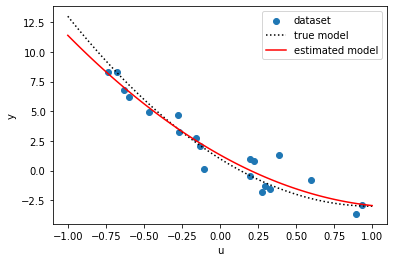

In [39]:
# DEBUG
# check that everything works

# set the parameters
alpha = 0.5
beta  = 1.0
sigma = 1.0
theta_true = [1, -8, 4]
    
# create the noisy dataset
noiseless_y = arbitrary_poly(theta_true) # use the lambda function
y = noiseless_y( u ) + noise( alpha, beta, sigma, len(u) )

# solve the LS problem
[theta_hat, d] = LS_solver( u, y, theta_true )
print(d)

# compute the estimated model
modeled_y = arbitrary_poly(theta_hat) # use the lambda function

# plot the true model against the measurements and the estimated model
x = np.linspace(start = min_u, stop = max_u, num = 100)
plt.figure()
plt.scatter(u, y,                 label = 'dataset')
plt.plot(x, noiseless_y(x), 'k:', label = 'true model')
plt.plot(x, modeled_y(x),   'r',  label = 'estimated model')
plt.xlabel('u')
plt.ylabel('y')
plt.legend();


# task 1.4

Make and comment these plots:

1.4.1) letting $\alpha = 1$, how does $d$ depend on $\sigma$?
Both the value and variance of d increases for increased sigma.

1.4.2) letting $\alpha = 0$, how does $d$ depend on $\beta$?
The relationship between d and beta is similar to that of d and sigma, although the variance of d seems to increase more rapidly

1.4.3) letting $\sigma = \beta = 1$, how does $d$ depend on $\alpha$?
the value of d seems to be mostly independent of alpha, as it mostly appears to be noise with mean 1 and a slight bias in the positive direction. This makes sense since d cannot be less than 0. Also note that d is never zero, meaning that we never achieve an LS-estimate that is on the manifold of the data set.

In [40]:
# randomize also on the true models -- storage allocation
n_models = 1000
thetas_true = np.random.normal(0, 1, size = (n_models, 3))

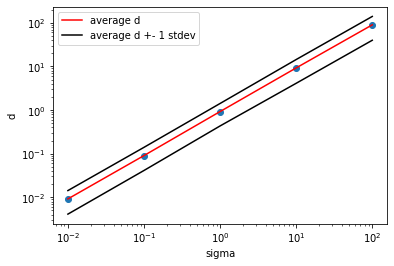

In [41]:
# 1.4.1 - letting $\alpha = 1$, how does $d$ depend on $\sigma$?

# set the fixed parameters
alpha = 1
beta  = 1

# generate all the parameters that shall be checked 
sigmas = np.logspace(-2, 2, 5) # typically better to use logarithmic scales than linear

# storage allocation
ds_sigmas = np.zeros((len(sigmas), n_models))

# cycle on the sigmas
for i, sigma in enumerate(sigmas):
    
    # cycle on the true models
    for j, theta_true in enumerate(thetas_true):
        
        # generate the dataset
        noiseless_y = arbitrary_poly(theta_true) # use the lambda function
        y = noiseless_y( u ) + noise( alpha, beta, sigma, len(u) )

        # solve the LS problem
        [theta_hat, d] = LS_solver( u, y, theta_true )
        
        # save the computed distance
        ds_sigmas[i,j] = d
                
        # print debug info
#        print('sigma:      ', sigma)
#        print('j:          ', j)
#        print('theta_true: ', theta_true)
#        print('theta_hat:  ', theta_hat)
#        print('d:          ', d, '\n')

# plot the true model against the measurements and the estimated model
plt.figure()
plt.plot(sigmas, np.mean(ds_sigmas, axis = 1), 'r', label = 'average d')
plt.plot(sigmas, np.mean(ds_sigmas, axis = 1) + np.std(ds_sigmas, axis = 1), 'k', label = 'average d +- 1 stdev')
plt.plot(sigmas, np.mean(ds_sigmas, axis = 1) - np.std(ds_sigmas, axis = 1), 'k')
plt.scatter(sigmas, np.mean(ds_sigmas, axis = 1))
plt.xlabel('sigma')
plt.ylabel('d')
plt.xscale('log')
plt.yscale('log')
plt.legend();


## comments to 1.4.1

The distance between the dataset and the LS estimate seems to increase linearly in the log-log plot, which is an exponential relationship between the error and sigma.

The gaussian noise that is present in the dataset is not considered when solving the optimization problem, i.e. we are not utilizing information about the noise that is embedded in our data, which leads to an error that increases with increasing sigma.

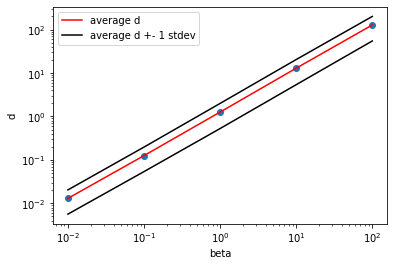

In [43]:
# 1.4.2 - letting $\alpha = 0$, how does $d$ depend on $\beta$?

# set the fixed parameters
alpha = 0
sigma = 1

# generate all the parameters that shall be checked 
betas = np.logspace(-2, 2, 5) # typically better to use logarithmic scales than linear

# storage allocation
ds_betas = np.zeros((len(betas), n_models))

# cycle on the sigmas
for i, beta in enumerate(betas):
    
    # cycle on the true models
    for j, theta_true in enumerate(thetas_true):
        
        # generate the dataset
        noiseless_y = arbitrary_poly(theta_true) # use the lambda function
        y = noiseless_y( u ) + noise( alpha, beta, sigma, len(u) )

        # solve the LS problem
        [theta_hat, d] = LS_solver( u, y, theta_true )
        
        # save the computed distance
        ds_betas[i,j] = d
                
        # print debug info
#        print('beta:       ', beta)
#        print('j:          ', j)
#        print('theta_true: ', theta_true)
#        print('theta_hat:  ', theta_hat)
#        print('d:          ', d, '\n')

# plot the true model against the measurements and the estimated model
plt.figure()
plt.plot(betas, np.mean(ds_betas, axis = 1), 'r', label = 'average d')
plt.plot(betas, np.mean(ds_betas, axis = 1) + np.std(ds_betas, axis = 1), 'k', label = 'average d +- 1 stdev')
plt.plot(betas, np.mean(ds_betas, axis = 1) - np.std(ds_betas, axis = 1), 'k')
plt.scatter(betas, np.mean(ds_betas, axis = 1))
plt.xlabel('beta')
plt.ylabel('d')
plt.xscale('log')
plt.yscale('log')
plt.legend();

## comments to 1.4.2

Similarly to 1.4.1, the error d increases linearly with beta in the log-log plot, which again shows an exponential relationship between the error and beta. The similarities between this and 1.4.1 makes sense considering that the Laplacian distribution is pretty much a "sharper version" of the gaussian. The sharper peaks leads to tighter

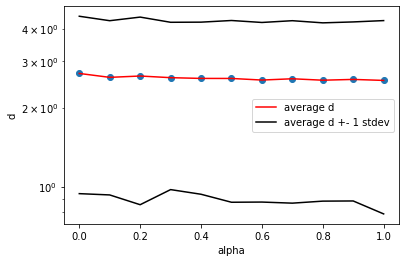

In [32]:
# 1.4.3 - letting $\sigma = \beta = 1$, how does $d$ depend on $\alpha$?

# set the fixed parameters
beta = 1
sigma = 1

# generate all the parameters that shall be checked 
alphas = np.linspace(0, 1, 11) # here instead better to use a linear scale

# storage allocation
ds_alphas = np.zeros((len(alphas), n_models))

# cycle on the sigmas
for i, alpha in enumerate(alphas):
    
    # cycle on the true models
    for j, theta_true in enumerate(thetas_true):
        
        # generate the dataset
        noiseless_y = arbitrary_poly(theta_true) # use the lambda function
        y = noiseless_y( u ) + noise( alpha, beta, sigma, len(u) )

        # solve the LS problem
        [theta_hat, d] = LS_solver( u, y, theta_true )
        
        # save the computed distance
        ds_alphas[i,j] = d
                
        # print debug info
#        print('alpha:      ', alpha)
#        print('j:          ', j)
#        print('theta_true: ', theta_true)
#        print('theta_hat:  ', theta_hat)
#        print('d:          ', d, '\n')

# plot the true model against the measurements and the estimated model
plt.figure()
plt.plot(alphas, np.mean(ds_alphas, axis = 1), 'r', label = 'average d')
plt.plot(alphas, np.mean(ds_alphas, axis = 1) + np.std(ds_alphas, axis = 1), 'k', label = 'average d +- 1 stdev')
plt.plot(alphas, np.mean(ds_alphas, axis = 1) - np.std(ds_alphas, axis = 1), 'k')
plt.scatter(alphas, np.mean(ds_alphas, axis = 1))
plt.xlabel('alpha')
plt.ylabel('d')
plt.yscale('log')
plt.legend();

## comments to 1.4.3

This plot confirms the hypothesis/expectation from 1.4.2. Since higher alpha means that the Laplacian distribution is more likely to be the noise model, the average d decreases as alpha goes to 1. This is due to how the Laplacian noise will have less variance around zero, meaning that the noise term in the model is lower, which in turn lowers the error term from the LS estimates